In [ ]:
import os, math, time, random, urllib.request
from dataclasses import dataclass
from typing import Tuple

import sys, subprocess
def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

pip_install([
    "kornia==0.8.2",
    "torch",
    "torchvision",
    "matplotlib",
    "numpy",
    "opencv-python-headless"
])

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import cv2

import kornia
import kornia.augmentation as K
import kornia.geometry.transform as KG
from kornia.geometry.ransac import RANSAC
from kornia.feature import LoFTR

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch:", torch.__version__)
print("Kornia:", kornia.__version__)
print("Device:", device)

In [ ]:
def to_tensor_img_uint8(img_bgr_uint8: np.ndarray) -> torch.Tensor:
    img_rgb = cv2.cvtColor(img_bgr_uint8, cv2.COLOR_BGR2RGB)
    t = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0
    return t.unsqueeze(0)

def show(img_t: torch.Tensor, title: str = "", max_size: int = 900):
    x = img_t.detach().float().cpu().clamp(0, 1)
    if x.shape[1] == 1:
        x = x.repeat(1, 3, 1, 1)
    x = x[0].permute(1, 2, 0).numpy()
    h, w = x.shape[:2]
    scale = min(1.0, max_size / max(h, w))
    if scale < 1.0:
        x = cv2.resize(x, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)
    plt.figure(figsize=(7, 5))
    plt.imshow(x)
    plt.axis("off")
    plt.title(title)
    plt.show()

def show_mask(mask_t: torch.Tensor, title: str = ""):
    x = mask_t.detach().float().cpu().clamp(0, 1)[0, 0].numpy()
    plt.figure(figsize=(6, 4))
    plt.imshow(x)
    plt.axis("off")
    plt.title(title)
    plt.show()

def download(url: str, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    if not os.path.exists(path):
        urllib.request.urlretrieve(url, path)

def safe_download(url: str, path: str) -> bool:
    try:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        if not os.path.exists(path):
            urllib.request.urlretrieve(url, path)
        return True
    except Exception as e:
        print("Download failed:", e)
        return False

def make_grid_mask(h: int, w: int, cell: int = 32) -> torch.Tensor:
    yy, xx = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
    m = (((yy // cell) % 2) ^ ((xx // cell) % 2)).float()
    return m.unsqueeze(0).unsqueeze(0)

def draw_matches(img0_rgb: np.ndarray, img1_rgb: np.ndarray, pts0: np.ndarray, pts1: np.ndarray, max_draw: int = 200) -> np.ndarray:
    h0, w0 = img0_rgb.shape[:2]
    h1, w1 = img1_rgb.shape[:2]
    out = np.zeros((max(h0, h1), w0 + w1, 3), dtype=np.uint8)
    out[:h0, :w0] = img0_rgb
    out[:h1, w0:w0+w1] = img1_rgb
    n = min(len(pts0), len(pts1), max_draw)
    if n == 0:
        return out
    idx = np.random.choice(len(pts0), size=n, replace=False) if len(pts0) > n else np.arange(n)
    for i in idx:
        x0, y0 = pts0[i]
        x1, y1 = pts1[i]
        x1_shift = x1 + w0
        p0 = (int(round(x0)), int(round(y0)))
        p1 = (int(round(x1_shift)), int(round(y1)))
        cv2.circle(out, p0, 2, (255, 255, 255), -1, lineType=cv2.LINE_AA)
        cv2.circle(out, p1, 2, (255, 255, 255), -1, lineType=cv2.LINE_AA)
        cv2.line(out, p0, p1, (255, 255, 255), 1, lineType=cv2.LINE_AA)
    return out

def normalize_img_for_loftr(img_rgb01: torch.Tensor) -> torch.Tensor:
    if img_rgb01.shape[1] == 3:
        return kornia.color.rgb_to_grayscale(img_rgb01)
    return img_rgb01

In [ ]:
print("\n[1] Differentiable augmentations: image + mask + keypoints")

B, C, H, W = 1, 3, 256, 384
img = torch.rand(B, C, H, W, device=device)
mask = make_grid_mask(H, W, cell=24).to(device)

kps = torch.tensor([[
    [40.0, 40.0],
    [W - 50.0, 50.0],
    [W * 0.6, H * 0.8],
    [W * 0.25, H * 0.65],
]], device=device)

aug = K.AugmentationSequential(
    K.RandomResizedCrop((224, 224), scale=(0.6, 1.0), ratio=(0.8, 1.25), p=1.0),
    K.RandomHorizontalFlip(p=0.5),
    K.RandomRotation(degrees=18.0, p=0.7),
    K.ColorJiggle(0.2, 0.2, 0.2, 0.1, p=0.8),
    data_keys=["input", "mask", "keypoints"],
    same_on_batch=True
).to(device)

img_aug, mask_aug, kps_aug = aug(img, mask, kps)

print("image:", tuple(img.shape), "->", tuple(img_aug.shape))
print("mask :", tuple(mask.shape), "->", tuple(mask_aug.shape))
print("kps  :", tuple(kps.shape), "->", tuple(kps_aug.shape))
print("Example keypoints (before -> after):")
print(torch.cat([kps[0], kps_aug[0]], dim=1))

show(img, "Original (synthetic)")
show_mask(mask, "Original mask (synthetic)")
show(img_aug, "Augmented (synced)")
show_mask(mask_aug, "Augmented mask (synced)")

In [ ]:
print("\n[2] Differentiable homography alignment by optimization")

base = torch.rand(1, 1, 240, 320, device=device)
show(base, "Base image (grayscale)")

true_H_px = torch.eye(3, device=device).unsqueeze(0)
true_H_px[:, 0, 2] = 18.0
true_H_px[:, 1, 2] = -12.0
true_H_px[:, 0, 1] = 0.03
true_H_px[:, 1, 0] = -0.02
true_H_px[:, 2, 0] = 1e-4
true_H_px[:, 2, 1] = -8e-5

target = KG.warp_perspective(base, true_H_px, dsize=(base.shape[-2], base.shape[-1]), align_corners=True)
show(target, "Target (base warped by true homography)")

p = torch.zeros(1, 8, device=device, requires_grad=True)

def params_to_H(p8: torch.Tensor) -> torch.Tensor:
    Bp = p8.shape[0]
    Hm = torch.eye(3, device=p8.device).unsqueeze(0).repeat(Bp, 1, 1)
    Hm[:, 0, 0] = 1.0 + p8[:, 0]
    Hm[:, 0, 1] = p8[:, 1]
    Hm[:, 0, 2] = p8[:, 2]
    Hm[:, 1, 0] = p8[:, 3]
    Hm[:, 1, 1] = 1.0 + p8[:, 4]
    Hm[:, 1, 2] = p8[:, 5]
    Hm[:, 2, 0] = p8[:, 6]
    Hm[:, 2, 1] = p8[:, 7]
    return Hm

opt = torch.optim.Adam([p], lr=0.08)
losses = []
for step in range(120):
    opt.zero_grad(set_to_none=True)
    H_est = params_to_H(p)
    pred = KG.warp_perspective(base, H_est, dsize=(base.shape[-2], base.shape[-1]), align_corners=True)
    loss_photo = (pred - target).abs().mean()
    loss_reg = 1e-3 * (p ** 2).mean()
    loss = loss_photo + loss_reg
    loss.backward()
    opt.step()
    losses.append(loss.item())

print("Final loss:", losses[-1])
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("Homography optimization loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

H_est_final = params_to_H(p.detach())
pred_final = KG.warp_perspective(base, H_est_final, dsize=(base.shape[-2], base.shape[-1]), align_corners=True)
show(pred_final, "Recovered warp (optimized)")
show((pred_final - target).abs(), "Abs error (recovered vs target)")

print("True H (pixel):\n", true_H_px.squeeze(0).detach().cpu().numpy())
print("Est  H:\n", H_est_final.squeeze(0).detach().cpu().numpy())

In [ ]:
print("\n[3] LoFTR matching + RANSAC homography + stitching (403-safe)")

data_dir = "/content/kornia_demo"
os.makedirs(data_dir, exist_ok=True)

img0_path = os.path.join(data_dir, "img0.png")
img1_path = os.path.join(data_dir, "img1.png")

ok0 = safe_download(
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/graf1.png",
    img0_path
)
ok1 = safe_download(
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/graf3.png",
    img1_path
)

if not (ok0 and ok1):
    print("⚠️ Using synthetic fallback images (no network / blocked downloads)")

    base_rgb = torch.rand(1, 3, 480, 640, device=device)
    H_syn = torch.tensor([[
        [1.0, 0.05, 40.0],
        [-0.03, 1.0, 25.0],
        [1e-4, -8e-5, 1.0]
    ]], device=device)

    t0 = base_rgb
    t1 = KG.warp_perspective(base_rgb, H_syn, dsize=(480, 640), align_corners=True)

    img0_rgb = (t0[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
    img1_rgb = (t1[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)

else:
    img0_bgr = cv2.imread(img0_path, cv2.IMREAD_COLOR)
    img1_bgr = cv2.imread(img1_path, cv2.IMREAD_COLOR)
    if img0_bgr is None or img1_bgr is None:
        raise RuntimeError("Failed to load downloaded images.")

    img0_rgb = cv2.cvtColor(img0_bgr, cv2.COLOR_BGR2RGB)
    img1_rgb = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)

    t0 = to_tensor_img_uint8(img0_bgr).to(device)
    t1 = to_tensor_img_uint8(img1_bgr).to(device)

show(t0, "Image 0")
show(t1, "Image 1")

g0 = normalize_img_for_loftr(t0)
g1 = normalize_img_for_loftr(t1)

loftr = LoFTR(pretrained="outdoor").to(device).eval()

with torch.inference_mode():
    correspondences = loftr({"image0": g0, "image1": g1})

mkpts0 = correspondences["keypoints0"]
mkpts1 = correspondences["keypoints1"]
mconf = correspondences.get("confidence", None)

print("Raw matches:", mkpts0.shape[0])

if mkpts0.shape[0] < 8:
    raise RuntimeError("Too few matches to estimate homography.")

if mconf is not None:
    mconf = mconf.detach()
    topk = min(2000, mkpts0.shape[0])
    idx = torch.topk(mconf, k=topk, largest=True).indices
    mkpts0 = mkpts0[idx]
    mkpts1 = mkpts1[idx]
    print("Kept top matches:", mkpts0.shape[0])

ransac = RANSAC(
    model_type="homography",
    inl_th=3.0,
    batch_size=4096,
    max_iter=10,
    confidence=0.999,
    max_lo_iters=5
).to(device)

with torch.inference_mode():
    H01, inliers = ransac(mkpts0, mkpts1)

print("Estimated H shape:", tuple(H01.shape))
print("Inliers:", int(inliers.sum().item()), "/", int(inliers.numel()))

vis = draw_matches(
    img0_rgb,
    img1_rgb,
    mkpts0.detach().cpu().numpy(),
    mkpts1.detach().cpu().numpy(),
    max_draw=250
)

plt.figure(figsize=(10,5))
plt.imshow(vis)
plt.axis("off")
plt.title("LoFTR matches (subset)")
plt.show()

H01 = H01.unsqueeze(0) if H01.ndim == 2 else H01
warped0 = KG.warp_perspective(t0, H01, dsize=(t1.shape[-2], t1.shape[-1]), align_corners=True)
stitched = torch.max(warped0, t1)

show(warped0, "Image0 warped into Image1 frame (via RANSAC homography)")
show(stitched, "Simple stitched blend (max)")

Torch: 2.9.0+cpu
Kornia: 0.8.2
Device: cpu

[1] Differentiable augmentations: image + mask + keypoints
image: (1, 3, 256, 384) -> (1, 3, 224, 224)
mask : (1, 1, 256, 384) -> (1, 1, 224, 224)
kps  : (1, 4, 2) -> (1, 4, 2)
Example keypoints (before -> after):
tensor([[ 40.0000,  40.0000,  28.2936,  15.2041],
        [334.0000,  50.0000, 264.3984,  49.5714],
        [230.4000, 204.8000, 165.5719, 185.6104],
        [ 96.0000, 166.4000,  60.9774, 138.2450]])


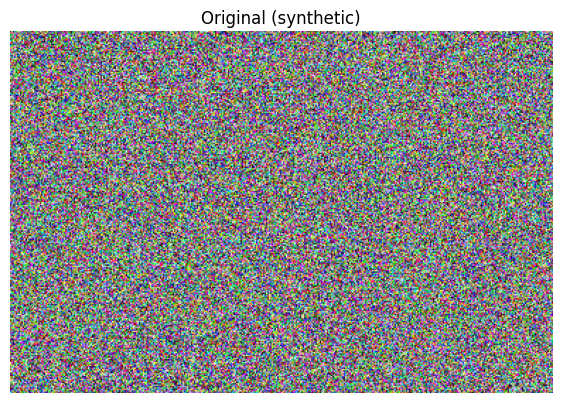

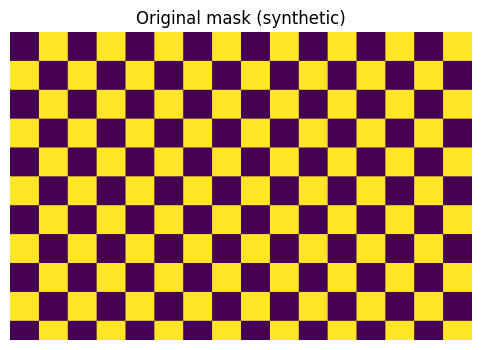

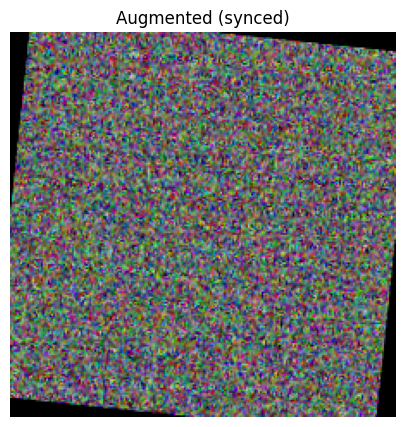

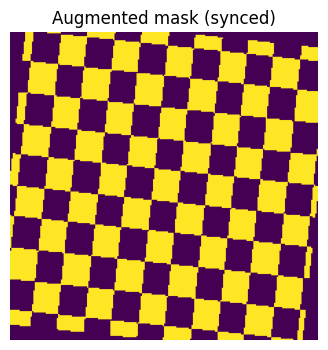


[2] Differentiable homography alignment by optimization


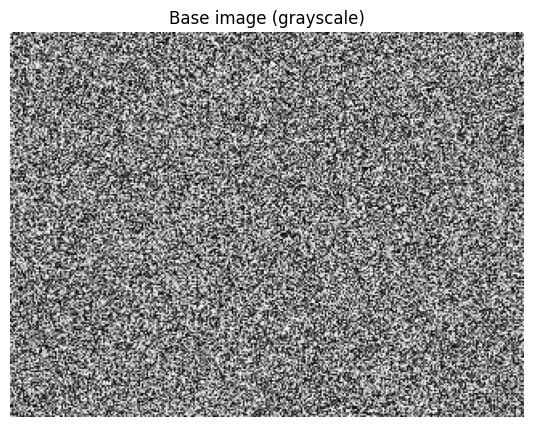

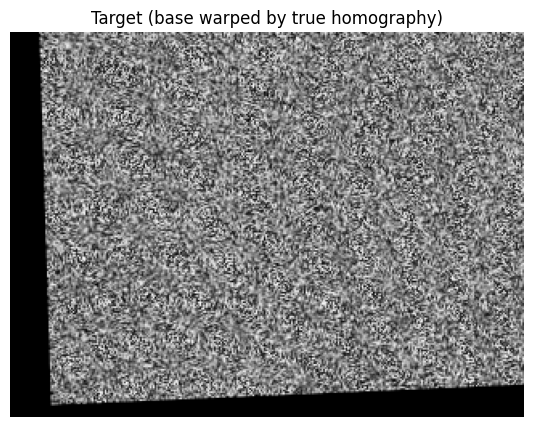

Final loss: 0.4399431347846985


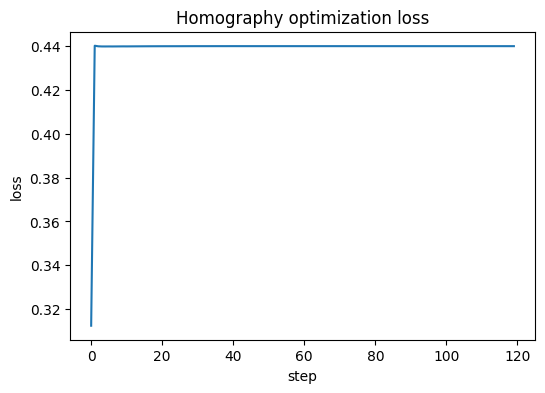

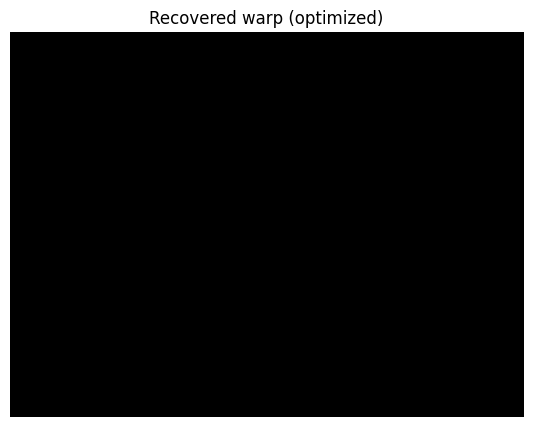

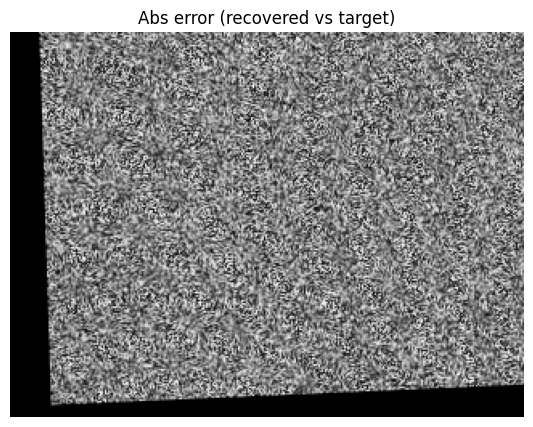

True H (pixel):
 [[ 1.0e+00  3.0e-02  1.8e+01]
 [-2.0e-02  1.0e+00 -1.2e+01]
 [ 1.0e-04 -8.0e-05  1.0e+00]]
Est  H:
 [[ 0.5195191  -0.47996983 -0.43093258]
 [-0.48049912  0.51985157 -0.43328312]
 [ 0.4804385   0.48042354  1.        ]]

[3] LoFTR matching + RANSAC homography + stitching (403-safe)


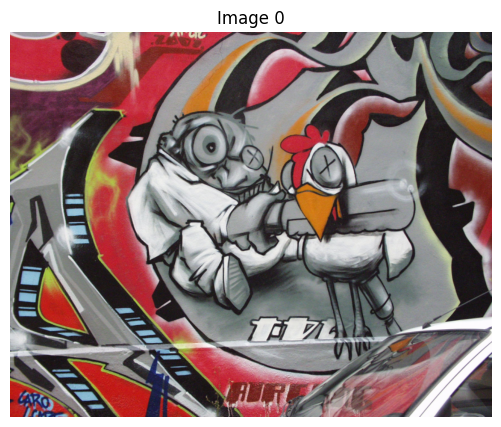

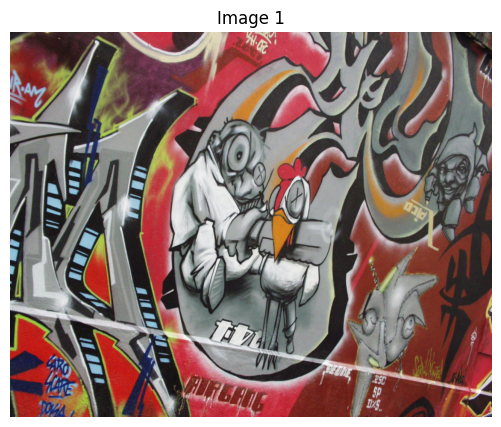

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /root/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt


100%|██████████| 44.2M/44.2M [00:04<00:00, 11.2MB/s]


Raw matches: 3581
Kept top matches: 2000
Estimated H shape: (3, 3)
Inliers: 1448 / 2000


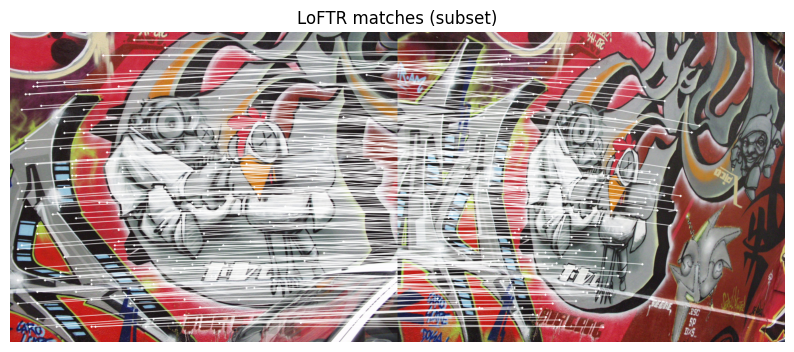

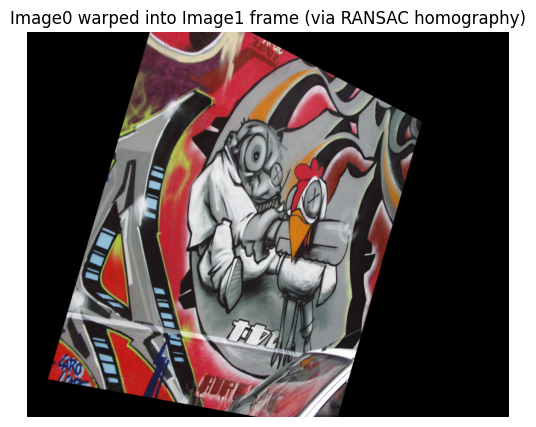

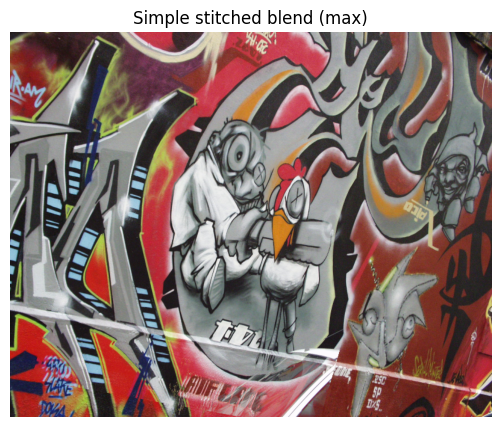


[4] Mini training loop with Kornia augmentations (fast subset)


100%|██████████| 170M/170M [00:10<00:00, 15.8MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


iter 010/16 | loss 2.2979
Done in 17.49 sec


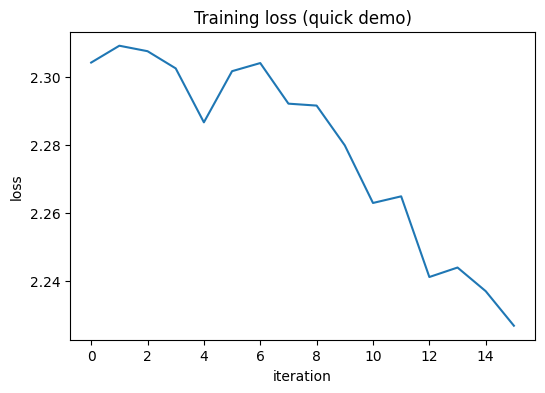

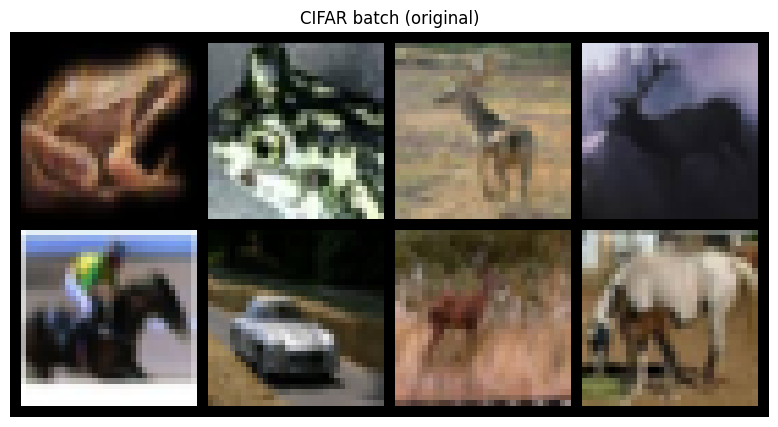

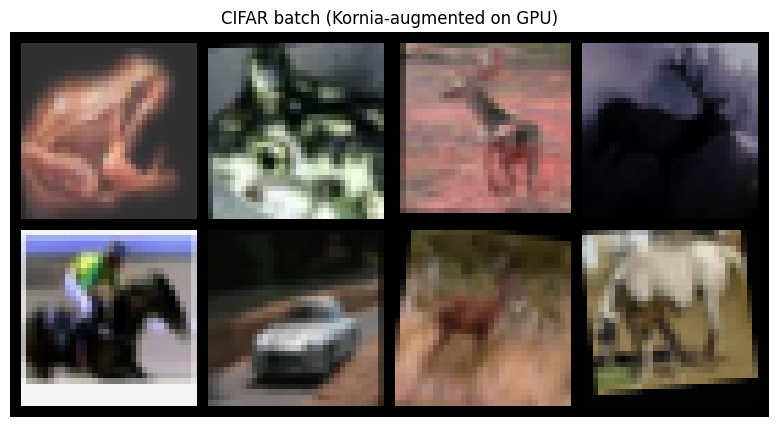


✅ Tutorial complete.
Next ideas:
- Feathered stitching (soft masks) instead of max-blend.
- Compare LoFTR vs DISK/LightGlue using kornia.feature.
- Multi-scale homography optimization + SSIM/Charbonnier losses.


In [3]:
print("\n[4] Mini training loop with Kornia augmentations (fast subset)")

cifar = torchvision.datasets.CIFAR10(root="/content/data", train=True, download=True)
num_samples = 4096
indices = np.random.permutation(len(cifar))[:num_samples]
subset = torch.utils.data.Subset(cifar, indices.tolist())

def collate(batch):
    imgs = []
    labels = []
    for im, y in batch:
        imgs.append(TF.to_tensor(im))
        labels.append(y)
    return torch.stack(imgs, 0), torch.tensor(labels)

loader = torch.utils.data.DataLoader(
    subset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate
)

aug_train = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.5),
    K.RandomAffine(degrees=12.0, translate=(0.08, 0.08), scale=(0.9, 1.1), p=0.7),
    K.ColorJiggle(0.2, 0.2, 0.2, 0.1, p=0.8),
    K.RandomGaussianBlur((3, 3), (0.1, 1.5), p=0.3),
).to(device)

class TinyCifarNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 48, 3, padding=1)
        self.conv2 = nn.Conv2d(48, 96, 3, padding=1)
        self.conv3 = nn.Conv2d(96, 128, 3, padding=1)
        self.head  = nn.Linear(128, num_classes)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = x.mean(dim=(-2, -1))
        return self.head(x)

model = TinyCifarNet().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

model.train()
t_start = time.time()
running = []
for it, (xb, yb) in enumerate(loader):
    xb = xb.to(device, non_blocking=True)
    yb = yb.to(device, non_blocking=True)

    xb = aug_train(xb)
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)

    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()

    running.append(loss.item())
    if (it + 1) % 10 == 0:
        print(f"iter {it+1:03d}/{len(loader)} | loss {np.mean(running[-10:]):.4f}")

    if it >= 39:
        break

print("Done in", round(time.time() - t_start, 2), "sec")
plt.figure(figsize=(6,4))
plt.plot(running)
plt.title("Training loss (quick demo)")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

xb0, yb0 = next(iter(loader))
xb0 = xb0[:8].to(device)
xbA = aug_train(xb0)

def tile8(x):
    x = x.detach().cpu().clamp(0,1)
    grid = torchvision.utils.make_grid(x, nrow=4)
    return grid.permute(1,2,0).numpy()

plt.figure(figsize=(10,5))
plt.imshow(tile8(xb0))
plt.axis("off")
plt.title("CIFAR batch (original)")
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(tile8(xbA))
plt.axis("off")
plt.title("CIFAR batch (Kornia-augmented on GPU)")
plt.show()

print("\n✅ Tutorial complete.")
print("Next ideas:")
print("- Feathered stitching (soft masks) instead of max-blend.")
print("- Compare LoFTR vs DISK/LightGlue using kornia.feature.")
print("- Multi-scale homography optimization + SSIM/Charbonnier losses.")